In [38]:
import os
import sys
sys.path.append('/home/cocoza4/workspace/absorouteio/asr-face-recognition/src')

import math
import time
import argparse
import logging
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import backend as K
from datetime import datetime
from functools import partial
from pathlib import Path
import matplotlib.pyplot as plt

from tensorflow_serving.apis import model_pb2
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_log_pb2

import models

K.set_learning_phase(0)

tf.__version__

'2.1.0'

In [23]:
def load_ckpt(ckpt_dir, model):
    ckpt = tf.train.Checkpoint(model=model)
    ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=5)
 
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("Restored from {}".format(ckpt_manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")

    return ckpt_manager

In [48]:
backbone = 'resnet34'
embedding_size = 512
image_size = 112
ckpt_dir = '/home/cocoza4/models/arcface_models/resnet34'
export_dir = '/home/cocoza4/models/exports/arcface_resnet34'

In [25]:
model = models.create_model(backbone, embedding_size)
load_ckpt(ckpt_dir, model)

Restored from /home/cocoza4/models/arcface_models/resnet34/resnet34-23


In [26]:
inp_spec = tf.TensorSpec(shape=[None, image_size, image_size, 3], dtype=tf.float32, name="inputs")
# pred_fn = tf.function(model.call)
# pred_fn

In [27]:
@tf.function(input_signature=[inp_spec])
def pred_fn(x):
    embeddings = tf.nn.l2_normalize(model(x, training=False), axis=-1)
    return {'embeddings': embeddings}

In [28]:
tf.saved_model.save(model, export_dir, signatures=pred_fn.get_concrete_function(inp_spec))

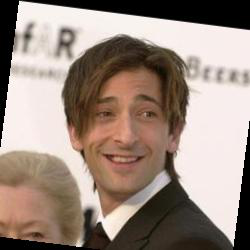

In [40]:
image_path = '/home/cocoza4/datasets/lfw-deepfunneled-samples/Adrien_Brody/Adrien_Brody_0011.jpg'
image = Image.open(image_path)
image

In [41]:
image.size

(250, 250)

In [42]:
inputs = np.asarray(image.resize((image_size, image_size)), dtype=np.float32)
inputs -= 127.5
inputs *= 0.0078125
inputs.shape

(112, 112, 3)

In [57]:
np.expand_dims(image.resize((image_size, image_size)), axis=0).astype(np.float32).shape

(1, 112, 112, 3)

Save warmup data

In [49]:
assets_extra_path = os.path.join(export_dir, 'assets.extra')
os.mkdir(assets_extra_path)

In [51]:
warmup_reqs_path = os.path.join(assets_extra_path, 'tf_serving_warmup_requests')  
with tf.io.TFRecordWriter(warmup_reqs_path) as writer:
    request = predict_pb2.PredictRequest(
        model_spec=model_pb2.ModelSpec(name='serving_default'),
        inputs={'inputs': tf.compat.v1.make_tensor_proto(np.expand_dims(inputs, axis=0), dtype=np.float32)}
    )
    log = prediction_log_pb2.PredictionLog(predict_log=prediction_log_pb2.PredictLog(request=request))
    writer.write(log.SerializeToString())

In [33]:
loaded = tf.saved_model.load(export_dir)
loaded

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f9e09c23860>

In [34]:
loaded.signatures

_SignatureMap({'serving_default': <tensorflow.python.saved_model.load._WrapperFunction object at 0x7f9dccca44e0>})

In [35]:
f = loaded.signatures["serving_default"]
f

In [36]:
f(tf.expand_dims(inputs, axis=0))

{'embeddings': <tf.Tensor: shape=(1, 512), dtype=float32, numpy=
 array([[ 4.11370993e-02,  2.23238468e-02,  4.00129892e-02,
         -4.97494563e-02,  1.09168943e-02,  5.90568990e-04,
          2.38740277e-02, -2.28751842e-02, -1.79363228e-02,
         -5.86809330e-02,  3.15068252e-02,  2.23432779e-02,
         -3.00188698e-02, -1.30291119e-01, -3.88847813e-02,
          4.04849183e-04, -6.79840846e-03, -1.65815139e-03,
          6.92821592e-02,  7.31388256e-02,  3.70668024e-02,
         -3.57416905e-02,  8.35700368e-04, -2.52609868e-02,
         -7.44623765e-02,  1.23763077e-01, -3.95402499e-02,
          2.51917541e-02, -2.47920603e-02,  2.09282003e-02,
         -2.54186266e-03, -1.25343557e-02, -2.37872303e-02,
         -8.19012895e-03,  7.46667534e-02, -4.84602749e-02,
         -2.96936985e-02,  1.45304529e-02,  2.28980910e-02,
         -1.42244073e-02,  3.50832641e-02, -3.19294073e-02,
         -2.68087462e-02, -6.17466159e-02, -1.02425311e-02,
         -7.63943046e-03, -7.671693